# Analyze and Visualize Solar Installations in the USA
## Map against unemployment and sunniness by county

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import requests
import gmaps
import matplotlib.pyplot as plt
from census import Census
from us import states
from api_keys import census_key, gov_key, gkey

In [3]:
# Set up API wrappers with API keys
gmaps.configure(api_key=gkey)

In [4]:
c = Census(census_key, year=2016)

In [5]:
# Download population and unemployment by state and county
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E","B23025_005E"), {'for': 'county:*'})

In [6]:
# Look at the first data point
census_data[0]

{'NAME': 'Autauga County, Alabama',
 'B19013_001E': 53099.0,
 'B01003_001E': 55049.0,
 'B01002_001E': 37.8,
 'B19301_001E': 26168.0,
 'B17001_002E': 6697.0,
 'B23025_005E': 1437.0,
 'state': '01',
 'county': '001'}

In [7]:
# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_005E": "Unemployment",
                                      "NAME": "Name", "state": "State", "county":"County"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Unemployment Rate
census_pd['Unemployment Rate'] = census_pd['Unemployment'].astype(int) / census_pd['Population'].astype(int)
# Final DataFrame
census_pd = census_pd[["State", "County", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate",'Unemployment Rate']]

# Visualize
print(len(census_pd))
census_pd.head()

3220


,State,County,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate
0,01,001,55049.0,37.8,53099.0,26168.0,6697.0,0.121655,0.026104
1,01,003,199510.0,42.3,51365.0,28069.0,25551.0,0.128069,0.029507
2,01,005,26614.0,38.7,33956.0,17249.0,6235.0,0.234275,0.049711
3,01,007,22572.0,40.2,39776.0,18988.0,3390.0,0.150186,0.028487
4,01,009,57704.0,40.8,46212.0,21033.0,9441.0,0.163611,0.023690


In [8]:
# Investigate counties with very high unemployment rates

census_pd.sort_values('Unemployment Rate', ascending=False).head(20)

,State,County,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Unemployment Rate
2376,46,031,4170.0,29.7,32115.0,13830.0,1929.0,0.462590,0.128537
2427,46,137,2818.0,28.3,36552.0,14047.0,1106.0,0.392477,0.128460
3158,72,033,26137.0,37.8,18562.0,11039.0,12829.0,0.490837,0.125187
3183,72,081,28052.0,40.4,12410.0,7958.0,15984.0,0.569799,0.124626
3142,72,001,18760.0,38.9,11296.0,7124.0,11791.0,0.628518,0.120309
2381,46,041,5652.0,28.5,40585.0,16305.0,1545.0,0.273355,0.111642
3168,72,053,33912.0,39.8,19482.0,10784.0,14866.0,0.438370,0.110698
3187,72,089,19237.0,39.6,19658.0,10617.0,8450.0,0.439258,0.108333
1460,28,119,7634.0,39.0,24835.0,14928.0,2799.0,0.366649,0.103877
3186,72,087,27857.0,36.5,18154.0,8694.0,13785.0,0.494849,0.103493


In [9]:
# Import ZIP code location info from http://download.geonames.org/export/zip/
zip_code_info = pd.read_csv('/Users/seantibbitts/Downloads/US/US.txt', sep = '\t', header=None, dtype={1:str},
                            names=['Country','zipcode','City','State','State Code','Unk1','Unk2','Unk3','Unk4','Lat','Lng','Unk5'])

In [10]:
zip_code_info.head()

,Country,zipcode,City,State,State Code,Unk1,Unk2,Unk3,Unk4,Lat,Lng,Unk5
0,US,99553,Akutan,Alaska,AK,Aleutians East,13.0,NaN,NaN,54.1430,-165.7854,1.0
1,US,99571,Cold Bay,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.1858,-162.7211,1.0
2,US,99583,False Pass,Alaska,AK,Aleutians East,13.0,NaN,NaN,54.8542,-163.4113,1.0
3,US,99612,King Cove,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.0628,-162.3056,1.0
4,US,99661,Sand Point,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.3192,-160.4914,1.0


In [11]:
zip_code_info.dtypes

Country        object
zipcode        object
City           object
State          object
State Code     object
Unk1           object
Unk2          float64
Unk3           object
Unk4          float64
Lat           float64
Lng           float64
Unk5          float64
dtype: object

In [12]:
# Attempt to map counties
import gmaps.geojson_geometries

In [13]:
counties_geojson = gmaps.geojson_geometries.load_geometry('us-counties')

In [14]:
fig = gmaps.figure()
counties_layer = gmaps.geojson_layer(counties_geojson)
fig.add_layer(counties_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [15]:
counties_geojson['features'][0]

{'type': 'Feature',
 'properties': {'GEO_ID': '0500000US01001',
  'STATE': '01',
  'COUNTY': '001',
  'NAME': 'Autauga',
  'LSAD': 'County',
  'CENSUSAREA': 594.436},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-86.496774, 32.344437],
    [-86.717897, 32.402814],
    [-86.814912, 32.340803],
    [-86.890581, 32.502974],
    [-86.917595, 32.664169],
    [-86.71339, 32.661732],
    [-86.714219, 32.705694],
    [-86.413116, 32.707386],
    [-86.411172, 32.409937],
    [-86.496774, 32.344437]]]}}

In [16]:
# Create a map from state, county to per capita income
county2income = {(row['State'],row['County']):row['Per Capita Income'] for i, row in census_pd.iterrows()}

In [17]:
county2income[('06','065')]

24443.0

In [18]:
# We will need to scale the income values to lie between 0 and 1
min_inc = min(county2income.values())
max_inc = max(county2income.values())
inc_range = max_inc - min_inc

In [19]:
from matplotlib.cm import Greens
from matplotlib.colors import to_hex

def calculate_income(inc):
    # make income a number between 0 and 1
    normalized_inc = (inc - min_inc) / inc_range
    
    # transform the unemployment rate to a matplotlib color
    mpl_color = Greens(normalized_inc)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)

    return gmaps_color

In [20]:
# Need to map each county to a color
inc_colors = []

for feature in counties_geojson['features']:
    state = feature['properties']['STATE']
    county = feature['properties']['COUNTY']
    try:
        inc = county2income[(state,county)]
        color = calculate_income(inc)
    except KeyError:
        # no UR for that county: return default color
        color = (0, 0, 0, 0.3)
    inc_colors.append(color)

In [21]:
fig = gmaps.figure(center = (38.8283, -98.5795), zoom_level = 4)
counties_layer = gmaps.geojson_layer(counties_geojson, fill_color=inc_colors, stroke_color=inc_colors,
                                     fill_opacity=0.8)
fig.add_layer(counties_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
# Create a map from state, county to unemployment rate
county2unemploy = {(row['State'],row['County']):row['Unemployment Rate'] for i, row in census_pd.iterrows()}

In [23]:
# We will need to scale the UR values to lie between 0 and 1
min_ur = min(county2unemploy.values())
max_ur = max(county2unemploy.values())
ur_range = max_ur - min_ur

In [24]:
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

def calculate_color(ur):
    # make ur a number between 0 and 1
    normalized_ur = (ur - min_ur) / ur_range
    
    # invert unemployment rate so high unemployment gets a dark color
    inverse_ur = 1.0 - normalized_ur
    
    # transform the unemployment rate to a matplotlib color
    mpl_color = viridis(inverse_ur)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)

    return gmaps_color

In [25]:
# Need to map each county to a color
colors = []

for feature in counties_geojson['features']:
    state = feature['properties']['STATE']
    county = feature['properties']['COUNTY']
    try:
        ur = county2unemploy[(state,county)]
        color = calculate_color(ur)
    except KeyError:
        # no UR for that county: return default color
        color = (0, 0, 0, 0.3)
    colors.append(color)

In [26]:
fig = gmaps.figure(center = (38.8283, -98.5795), zoom_level = 4)
counties_layer = gmaps.geojson_layer(counties_geojson, fill_color=colors, stroke_color=colors, fill_opacity=0.8)
fig.add_layer(counties_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [27]:
# Create legend for unemployment rate
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

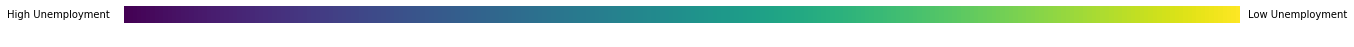

In [28]:
fig, ax = plt.subplots(nrows=1, figsize = (20, 0.3))
# fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('viridis'))
pos = list(ax.get_position().bounds)
x_text = pos[0] - 0.01
y_text = pos[1] + pos[3]/2.
fig.text(x_text, y_text, 'High Unemployment', va='center', ha='right', fontsize=10)
x_text2 = pos[2] + 0.13
fig.text(x_text2, y_text, 'Low Unemployment', va='center', ha='left', fontsize=10)
ax.set_axis_off()
plt.savefig('viridis.png', bbox_inches='tight')
plt.show()

### Solar Installs

In [29]:
# Import solar installs from https://openpv.nrel.gov/search
open_pv = pd.read_csv('/Users/seantibbitts/Downloads/openpv_all.csv', dtype = {'zipcode':str})

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (2,5,8,12,13,14,15,16,20,23,25,26,27,28,32,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
open_pv.head()

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,new_constr,effic_1,cust_county,tracking,inv_model_clean,mod_cost_real,inv_cost_real,bos_powerclerk_real,permitting_real,3rdparty
0,TX,12/12/2013,Austin Energy,uir,10.560,NaN,78702,residential,NaN,2.897777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TX,07/11/2014,Austin Energy,uir,12.720,NaN,78702,residential,NaN,3.144654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TX,01/17/2014,Austin Energy,uir,5.400,NaN,78702,residential,NaN,4.197330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IN,10/06/2017,NaN,uir,6.785,NaN,47403,Residential,Whole Sun Designs,2.590000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IN,10/06/2017,NaN,uir,4.720,NaN,47408,Residential,Whole Sun Designs,2.570000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
open_pv.shape

(1020945, 81)

In [32]:
open_pv.columns

Index(['state', 'date_installed', 'incentive_prog_names', 'type', 'size_kw',
       'appraised', 'zipcode', 'install_type', 'installer', 'cost_per_watt',
       'cost', 'lbnl_tts_version_year', 'lbnl_tts', 'city', 'utility_clean',
       'tech_1', 'model1_clean', 'county', 'annual_PV_prod',
       'annual_insolation', 'rebate', 'sales_tax_cost', 'tilt1',
       'tracking_type', 'azimuth1', 'manuf2_clean', 'manuf3_clean',
       'manuf1_clean', 'inv_man_clean', 'reported_annual_energy_prod',
       'incentivetype', 'year_app_implied', 'year', 'npv_fit_real',
       'application_implied', 'npv_pbi_real', 'other_incentive',
       'appraised_cluster', 'inflation', 'other_incentive_real',
       'zip_available', 'cust_city', 'pbi', 'pbi_real', 'pbi_length',
       'application', 'fit_length', 'fit_rate', 'fit_payment',
       '_3rdparty_implied', 'utility', 'install_price_real_w', 'install_price',
       'installer_clean', 'manuf1_', 'inverter_reported', 'rebate_real',
       'model1', '_3

In [33]:
open_pv['date_installed'].value_counts(dropna = False).sort_index()

01/01/1998       2
01/01/1999       6
01/01/2000      22
01/01/2001      10
01/01/2002      10
01/01/2003       5
01/01/2004      24
01/01/2005      39
01/01/2006      35
01/01/2007      65
01/01/2008     150
01/01/2009     290
01/01/2010      25
01/01/2011      35
01/01/2012      69
01/01/2013      15
01/01/2014      13
01/01/2015      91
01/01/2016       3
01/01/2017       1
01/02/1999       1
01/02/2002      18
01/02/2003       8
01/02/2004       1
01/02/2005       1
01/02/2006      10
01/02/2007      10
01/02/2008      50
01/02/2009     148
01/02/2010       4
              ... 
12/30/2005      59
12/30/2006      14
12/30/2007      16
12/30/2008     145
12/30/2009     373
12/30/2010     504
12/30/2011     492
12/30/2012      19
12/30/2013     654
12/30/2014    1127
12/30/2015    1065
12/30/2016       2
12/31/1969     119
12/31/1999       2
12/31/2001      35
12/31/2002      17
12/31/2003      15
12/31/2004      47
12/31/2005      12
12/31/2006      23
12/31/2007      88
12/31/2008  

In [34]:
# Convert install date to a datetime
open_pv['date_installed_dt'] = pd.to_datetime(open_pv['date_installed'])

In [35]:
open_pv['date_installed_dt'].value_counts(dropna = False).sort_index()

1909-07-07      4
1969-12-31    119
1983-06-01      1
1983-11-14      1
1984-12-01      1
1986-12-01      1
1988-08-23      1
1992-12-01      1
1994-01-25      1
1994-02-01      1
1994-03-08      2
1994-03-16      2
1994-03-31      1
1994-06-01      1
1994-10-07      1
1994-12-01      1
1994-12-30      1
1995-03-03      1
1995-06-01      1
1995-06-30      1
1995-07-05      2
1995-07-26      1
1995-07-27      1
1995-07-28      1
1995-08-01      1
1995-08-02      1
1995-08-10      1
1995-09-01      1
1995-10-27      1
1995-12-30      1
             ... 
2019-01-10      2
2019-01-11      1
2019-01-15      1
2019-01-16      1
2019-01-18      1
2019-01-21      1
2019-01-23      1
2019-01-25      1
2019-01-29      1
2019-02-01      1
2019-02-05      1
2019-02-06      2
2019-02-08      1
2019-02-11      3
2019-02-12      1
2019-02-13      1
2019-02-20      1
2019-02-22      1
2019-02-25      1
2019-02-26      1
2019-02-27      2
2019-03-01      1
2019-03-05      1
2019-03-13      1
2019-03-15

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


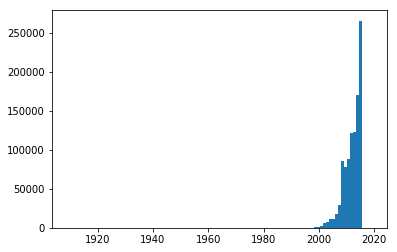

In [36]:
# Data (supposedly) goes back to 1909, but most installs from around 1998 to 2016
plt.hist(open_pv['date_installed_dt'].dt.year, bins=100)
plt.show()

In [37]:
# Try limiting to more recent installs
open_pv1 = open_pv[open_pv['date_installed_dt'] > '2016'].copy()

In [38]:
open_pv1.shape

(975, 82)

In [39]:
# open_pv2 = open_pv[open_pv['zipcode'].notnull()].copy()
# Above not necessary after limiting to recent
open_pv2 = open_pv1.copy()

In [40]:
open_pv2.dtypes

state                                  object
date_installed                         object
incentive_prog_names                   object
type                                   object
size_kw                               float64
appraised                              object
zipcode                                object
install_type                           object
installer                              object
cost_per_watt                         float64
cost                                  float64
lbnl_tts_version_year                 float64
lbnl_tts                               object
city                                   object
utility_clean                          object
tech_1                                 object
model1_clean                           object
county                                 object
annual_PV_prod                        float64
annual_insolation                     float64
rebate                                 object
sales_tax_cost                    

In [41]:
# Join solar install data to zip code lat/lon data
open_pv_w_loc = pd.merge(open_pv2, zip_code_info, how = 'left', on='zipcode')

In [42]:
open_pv_w_loc.head()

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,City,State,State Code,Unk1,Unk2,Unk3,Unk4,Lat,Lng,Unk5
0,IN,10/06/2017,NaN,uir,6.785,NaN,47403,Residential,Whole Sun Designs,2.59,...,Bloomington,Indiana,IN,Monroe,105.0,NaN,NaN,39.1263,-86.5769,4.0
1,IN,10/06/2017,NaN,uir,4.720,NaN,47408,Residential,Whole Sun Designs,2.57,...,Bloomington,Indiana,IN,Monroe,105.0,NaN,NaN,39.2303,-86.4692,4.0
2,IN,10/13/2017,NaN,uir,12.390,NaN,47429,Residential,Whole Sun Designs,2.60,...,Ellettsville,Indiana,IN,Monroe,105.0,NaN,NaN,39.2545,-86.6196,4.0
3,IN,10/17/2017,NaN,uir,6.700,NaN,47401,Residential,Whole Sun Designs,2.28,...,Bloomington,Indiana,IN,Monroe,105.0,NaN,NaN,39.1401,-86.5083,4.0
4,IN,10/23/2017,NaN,uir,4.130,NaN,47404,Residential,Whole Sun Designs,2.62,...,Bloomington,Indiana,IN,Monroe,105.0,NaN,NaN,39.1950,-86.5757,4.0


In [43]:
# Some null lats and longs, but not many
# (None after limiting to 2016+)
open_pv_w_loc[open_pv_w_loc['Lat'].isnull()].shape

(0, 93)

In [44]:
# Drop out null locations
open_pv_w_loc2 = open_pv_w_loc[open_pv_w_loc['Lat'].notnull() & open_pv_w_loc['Lng'].notnull()].copy()

In [45]:
# Normalize size_kw to lie between 0 and 10
min_size = open_pv_w_loc2['size_kw'].min()
max_size = open_pv_w_loc2['size_kw'].max()
size_range = max_size - min_size
open_pv_w_loc2['size_normed'] = (10 * (open_pv_w_loc2['size_kw'] - min_size)/size_range + 1).astype(int)

In [46]:
fig = gmaps.figure(center = (38.8283, -98.5795), zoom_level = 4)
install_locs = open_pv_w_loc2[['Lat','Lng']]
size = [int(x) for i, x in open_pv_w_loc2['size_normed'].iteritems()]

In [47]:
install_layer = gmaps.symbol_layer(install_locs, fill_opacity=.5, stroke_opacity = .5)

In [48]:
fig.add_layer(install_layer)

In [49]:
fig

Figure(layout=FigureLayout(height='420px'))

### Sunniness

In [50]:
# Import sunniness data by county from https://wonder.cdc.gov/nasa-insolar.html
sunny = pd.read_csv('/Users/seantibbitts/Downloads/North America Land Data Assimilation System (NLDAS) Daily Sunlight (KJm²) (1979-2011) (1).txt',
                    sep = '\t', dtype = {'County Code':str}, encoding = 'ISO-8859-1')

In [51]:
# Notes column is empty
sunny.head()

,Notes,County,County Code,Avg Daily Sunlight (KJ/m²)
0,NaN,"Autauga County, AL",01001,17103.72
1,NaN,"Baldwin County, AL",01003,17660.59
2,NaN,"Barbour County, AL",01005,17315.13
3,NaN,"Bibb County, AL",01007,16904.87
4,NaN,"Blount County, AL",01009,16393.63


In [52]:
# End of data has footer and total row
sunny.tail(15)

,Notes,County,County Code,Avg Daily Sunlight (KJ/m²)
3110,NaN,"Weston County, WY",56045,15923.65
3111,Total,NaN,NaN,16432.10
3112,---,NaN,NaN,NaN
3113,Dataset: North America Land Data Assimilation ...,NaN,NaN,NaN
3114,Query Parameters:,NaN,NaN,NaN
3115,Group By: County,NaN,NaN,NaN
3116,Show Totals: True,NaN,NaN,NaN
3117,Show Zero Values: True,NaN,NaN,NaN
3118,---,NaN,NaN,NaN
3119,Help: See http://wonder.cdc.gov/wonder/help/In...,NaN,NaN,NaN


In [53]:
# Cut out non-data footer and total row and drop Notes column
sunny_data = sunny.iloc[:3111].copy().drop('Notes', axis = 1)

In [54]:
sunny_data.head()

,County,County Code,Avg Daily Sunlight (KJ/m²)
0,"Autauga County, AL",01001,17103.72
1,"Baldwin County, AL",01003,17660.59
2,"Barbour County, AL",01005,17315.13
3,"Bibb County, AL",01007,16904.87
4,"Blount County, AL",01009,16393.63


In [55]:
# Slice county FIPS code into state code and county code
sunny_data['state_id'] = sunny_data['County Code'].str.slice(stop=2)
sunny_data['county_id'] = sunny_data['County Code'].str.slice(start=2)

In [56]:
sunny_data.head()

,County,County Code,Avg Daily Sunlight (KJ/m²),state_id,county_id
0,"Autauga County, AL",01001,17103.72,01,001
1,"Baldwin County, AL",01003,17660.59,01,003
2,"Barbour County, AL",01005,17315.13,01,005
3,"Bibb County, AL",01007,16904.87,01,007
4,"Blount County, AL",01009,16393.63,01,009


In [57]:
# Create a map between state/county and avg daily sunlight
county2sunny = {(row['state_id'],row['county_id']):row['Avg Daily Sunlight (KJ/m²)']
                for i, row in sunny_data.iterrows()}

In [58]:
# We will need to scale the sunniness values to lie between 0 and 1
min_sun = min(county2sunny.values())
max_sun = max(county2sunny.values())
sun_range = max_sun - min_sun

In [59]:
from matplotlib.cm import coolwarm
from matplotlib.cm import Reds

def calculate_sunny(sun):
    # make sunniness a number between 0 and 1
    normalized_sun = (sun - min_sun) / sun_range
    
    # transform the sunniness to a matplotlib color
    mpl_color = Reds(normalized_sun)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)

    return gmaps_color

In [60]:
sun_colors = []

for feature in counties_geojson['features']:
    state = feature['properties']['STATE']
    county = feature['properties']['COUNTY']
    try:
        sun = county2sunny[(state,county)]
        color = calculate_sunny(sun)
    except KeyError:
        # no sun for that county: return default color
        color = (0, 0, 0, 0.3)
    sun_colors.append(color)

In [61]:
fig = gmaps.figure(center = (38.8283, -98.5795), zoom_level = 4)
counties_layer = gmaps.geojson_layer(counties_geojson, fill_color=sun_colors, stroke_color=sun_colors,
                                     fill_opacity=0.8)
fig.add_layer(counties_layer)
install_locs = open_pv_w_loc2[['Lat','Lng']]
# hover_text = ["Size (kW): {}".format(row['size_kw']) for i, row in open_pv_w_loc2.iterrows()]
size = [int(x) for i, x in open_pv_w_loc2['size_normed'].iteritems()]
fig.add_layer(gmaps.symbol_layer(install_locs, fill_opacity=.5, stroke_opacity = .5,
                                 fill_color = 'blue',
                                 stroke_color = 'blue', scale = size))
fig

Figure(layout=FigureLayout(height='420px'))

In [62]:
open_pv_w_loc2.sort_values('size_kw', ascending=False).head()

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,State,State Code,Unk1,Unk2,Unk3,Unk4,Lat,Lng,Unk5,size_normed
54,TX,08/11/2016,NaN,uir,31191.00,NaN,75075,Residential,Axium Solar,NaN,...,Texas,TX,Collin,85.0,NaN,NaN,33.0250,-96.7397,4.0,11
113,TX,09/15/2017,NaN,uir,8791.35,NaN,75024,Commercial,Axium Solar,NaN,...,Texas,TX,Collin,85.0,NaN,NaN,33.0752,-96.7843,4.0,3
218,AL,01/04/2017,NaN,uir,3000.00,NaN,36912,Commercial,NaN,NaN,...,Alabama,AL,Choctaw,23.0,NaN,NaN,32.2177,-88.3234,4.0,1
839,IN,11/02/2018,NaN,uir,2721.00,NaN,47711,Commercial,"Morton Solar, LLC",1.3,...,Indiana,IN,Vanderburgh,163.0,NaN,NaN,38.0617,-87.5548,4.0,1
234,TX,01/06/2017,NaN,uir,1111.59,NaN,75211,Commercial,Axium Solar,NaN,...,Texas,TX,Dallas,113.0,NaN,NaN,32.7319,-96.9057,4.0,1


In [63]:
open_pv_w_loc2.loc[54].T

state                                           TX
date_installed                          08/11/2016
incentive_prog_names                           NaN
type                                           uir
size_kw                                      31191
appraised                                      NaN
zipcode                                      75075
install_type                           Residential
installer                              Axium Solar
cost_per_watt                                  NaN
cost                                           NaN
lbnl_tts_version_year                          NaN
lbnl_tts                                       NaN
city                                         Plano
utility_clean                                  NaN
tech_1                                         NaN
model1_clean                                   NaN
county                                         NaN
annual_PV_prod                                 NaN
annual_insolation              

## Clustering the Data for Visualization
### Limiting installs to >2016 appears to bias data, but gmaps package cannot handle full dataset.
### 1 million points is too many; cluster them using K-Means

In [64]:
# Go through process of joining on ZIP Code coordinates again
open_pv_cluster = open_pv[open_pv['zipcode'].notnull()].copy()

In [65]:
open_pv_cluster2 = pd.merge(open_pv_cluster, zip_code_info, how = 'left', on = 'zipcode')

In [66]:
# Drop out rows with null lat and lng
open_pv_cluster3 = open_pv_cluster2[open_pv_cluster2['Lat'].notnull() & open_pv_cluster2['Lng'].notnull()].copy()

In [67]:
# Limit to post-1993 (this contains the bulk of the data)
open_pv_cluster4 = open_pv_cluster3[open_pv_cluster3['date_installed_dt'] > '1993'].copy()

In [32]:
# open_pv_cluster4 = open_pv_cluster3.copy()

In [68]:
open_pv_cluster4.shape

(1020545, 93)

In [69]:
# Run mini-batch K-Means on data

from sklearn.cluster import MiniBatchKMeans
from datetime import datetime

print(datetime.now())

X = open_pv_cluster4[['Lat','Lng']]

kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0, batch_size=100).fit(X)

print(datetime.now())

2019-04-11 20:15:25.997025


/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


2019-04-11 20:15:34.931215


In [70]:
# Create new column with cluster indices
open_pv_cluster4['new_loc_ind'] = kmeans.predict(X)

In [71]:
# Turn predicted clusters into a DataFrame
new_locs = pd.DataFrame(kmeans.cluster_centers_, columns = ['new_lat','new_lng'])

In [72]:
# Merge simplified (clustered) locations onto main dataframe
open_pv_cluster5 = pd.merge(open_pv_cluster4, new_locs, how = 'left', left_on = 'new_loc_ind', right_index = True)

In [73]:
open_pv_cluster5.head()

,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,Unk1,Unk2,Unk3,Unk4,Lat,Lng,Unk5,new_loc_ind,new_lat,new_lng
0,TX,12/12/2013,Austin Energy,uir,10.560,NaN,78702,residential,NaN,2.897777,...,Travis,453.0,NaN,NaN,30.2638,-97.7166,4.0,543,30.28405,-97.6632
1,TX,07/11/2014,Austin Energy,uir,12.720,NaN,78702,residential,NaN,3.144654,...,Travis,453.0,NaN,NaN,30.2638,-97.7166,4.0,543,30.28405,-97.6632
2,TX,01/17/2014,Austin Energy,uir,5.400,NaN,78702,residential,NaN,4.197330,...,Travis,453.0,NaN,NaN,30.2638,-97.7166,4.0,543,30.28405,-97.6632
3,IN,10/06/2017,NaN,uir,6.785,NaN,47403,Residential,Whole Sun Designs,2.590000,...,Monroe,105.0,NaN,NaN,39.1263,-86.5769,4.0,108,38.17060,-87.0070
4,IN,10/06/2017,NaN,uir,4.720,NaN,47408,Residential,Whole Sun Designs,2.570000,...,Monroe,105.0,NaN,NaN,39.2303,-86.4692,4.0,108,38.17060,-87.0070


In [74]:
# Combine the clustered (re-mapped) points and sum the kW sizes of the installs
open_pv_cluster6 = open_pv_cluster5.groupby(['new_loc_ind','new_lat','new_lng'])['size_kw'].sum().reset_index()

### Tangent: Investigate huge cluster around Sacramento

In [75]:
open_pv_cluster6.sort_values('size_kw', ascending = False).head()

,new_loc_ind,new_lat,new_lng,size_kw
834,854,38.7703,-121.3372,1.050736e+06
587,601,33.3703,-112.5838,4.663684e+05
802,820,40.3324,-74.5688,1.278303e+05
825,844,29.4388,-98.4935,9.377957e+04
313,313,36.1624,-120.3489,8.958822e+04


In [76]:
# Size of Sacramento cluster
print('# of installs in Sac cluster: ',len(open_pv_cluster5.loc[open_pv_cluster5['new_loc_ind']==854]))

# of installs in Sac cluster:  1305


In [77]:
print('Sacramento cluster date range')
print('Min install date: ',open_pv_cluster5.loc[open_pv_cluster5['new_loc_ind']==854,'date_installed_dt'].min())
print('Max install date: ',open_pv_cluster5.loc[open_pv_cluster5['new_loc_ind']==854,'date_installed_dt'].max())

Sacramento cluster date range
Min install date:  2003-05-06 00:00:00
Max install date:  2015-12-30 00:00:00


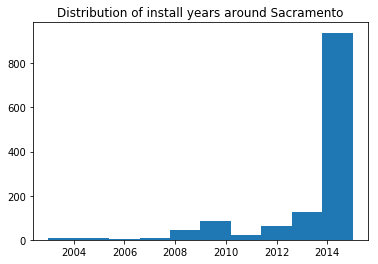

In [78]:
# Distribution of installs
plt.hist(open_pv_cluster5.loc[open_pv_cluster5['new_loc_ind']==854,'date_installed_dt'].dt.year)
plt.title('Distribution of install years around Sacramento')
plt.show()

In [79]:
open_pv_cluster6.shape

(977, 4)

### End Tangent
### Visualize Clustered Data

In [80]:
# Norm the kW size
min_size = open_pv_cluster6['size_kw'].min()
max_size = open_pv_cluster6['size_kw'].max()
size_range = max_size - min_size
open_pv_cluster6['size_normed'] = (10 * (open_pv_cluster6['size_kw'] - min_size)/size_range + 1).astype(int)

In [81]:
fig = gmaps.figure(center = (38.8283, -98.5795), zoom_level = 4)
counties_layer = gmaps.geojson_layer(counties_geojson, fill_color=sun_colors, stroke_color=sun_colors,
                                     fill_opacity=0.8)
fig.add_layer(counties_layer)
install_locs = open_pv_cluster6[['new_lat','new_lng']]
# hover_text = ["Size (kW): {}".format(row['size_kw']) for i, row in open_pv_w_loc2.iterrows()]
size = [int(x) for i, x in open_pv_cluster6['size_normed'].iteritems()]
fig.add_layer(gmaps.symbol_layer(install_locs, fill_opacity=.5, stroke_opacity = .5,
                                 fill_color = 'blue',
                                 stroke_color = 'blue', scale = size))
fig

Figure(layout=FigureLayout(height='420px'))

### Higher unemployment and higher sunniness

1. Combine unemployment rate and sunniness into a new measure using harmonic mean
2. Plot this combined measure against solar panel installs
3. Places where the combined rate is high and solar panel installs are low are potential untapped labor markets for green jobs

In [82]:
from matplotlib.cm import Blues

def calculate_sun_ur(sun, ur):
    # make sunniness a number between 0 and 1
    normalized_sun = (sun - min_sun) / sun_range
    
    # make ur a number between 0 and 1
    normalized_ur = (ur - min_ur) / ur_range
    
    # combine both rates using harmonic mean
    comb_rate = 2*(normalized_sun * normalized_ur)/(normalized_sun + normalized_ur)
    
    # transform the combined rate to a matplotlib color
    mpl_color = Blues(normalized_sun)

    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)

    return gmaps_color

In [83]:
comb_colors = []

for feature in counties_geojson['features']:
    state = feature['properties']['STATE']
    county = feature['properties']['COUNTY']
    try:
        sun = county2sunny[(state,county)]
        ur = county2unemploy[(state,county)]
        color = calculate_sun_ur(sun, ur)
    except KeyError:
        # no value for that county: return default color
        color = (0, 0, 0, 0.3)
    comb_colors.append(color)

In [84]:
fig = gmaps.figure(center = (38.8283, -98.5795), zoom_level = 4)
comb_counties_layer = gmaps.geojson_layer(counties_geojson, fill_color=comb_colors, stroke_color=comb_colors, fill_opacity=0.8)
fig.add_layer(comb_counties_layer)
install_locs = open_pv_cluster6[['new_lat','new_lng']]
# hover_text = ["Size (kW): {}".format(row['size_kw']) for i, row in open_pv_w_loc2.iterrows()]
size = [int(x) for i, x in open_pv_cluster6['size_normed'].iteritems()]
fig.add_layer(gmaps.symbol_layer(install_locs, fill_opacity=.5, stroke_opacity = .5,
                                 fill_color = 'blue',
                                 stroke_color = 'blue', scale = size))
fig

Figure(layout=FigureLayout(height='420px'))

## Solar Utilities
### The Open PV dataset is heavily biased towards California. Get solar utility locations from EIA.

In [85]:
# Import data downloaded from https://www.eia.gov/electricity/data/eia860/
eia_plants = pd.read_excel('/Users/seantibbitts/Downloads/eia8602017/2___Plant_Y2017.xlsx', skiprows=[0])
eia_solar = pd.read_excel('/Users/seantibbitts/Downloads/eia8602017/3_3_Solar_Y2017.xlsx', skiprows=[0])

In [74]:
eia_plants.head()

,Utility ID,Utility Name,Plant Code,Plant Name,Street Address,City,State,Zip,County,Latitude,...,Grid Voltage 2 (kV),Grid Voltage 3 (kV),Energy Storage,Natural Gas LDC Name,Natural Gas Pipeline Name 1,Natural Gas Pipeline Name 2,Natural Gas Pipeline Name 3,Pipeline Notes,Natural Gas Storage,Liquefied Natural Gas Storage
0,195,Alabama Power Co,2,Bankhead Dam,19001 Lock 17 Road,Northport,AL,35476,Tuscaloosa,33.4587,...,,,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195,Alabama Power Co,3,Barry,North Highway 43,Bucks,AL,36512,Mobile,31.0069,...,,,N,NaN,BAY GAS STORAGE,NaN,NaN,NaN,N,X
2,195,Alabama Power Co,4,Walter Bouldin Dam,750 Bouldin Dam Road,Wetumpka,AL,36092,Elmore,32.5839,...,,,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195,Alabama Power Co,7,Gadsden,1000 Goodyear Ave,Gadsden,AL,35903,Etowah,34.0128,...,,,N,NaN,SOUTHERN NATURAL GAS COMPANY,NaN,NaN,NaN,N,X
4,195,Alabama Power Co,8,Gorgas,460 Gorgas Road,Parrish,AL,35580,Walker,33.6443,...,,,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
eia_plants.columns

Index(['Utility ID', 'Utility Name', 'Plant Code', 'Plant Name',
       'Street Address', 'City', 'State', 'Zip', 'County', 'Latitude',
       'Longitude', 'NERC Region', 'Balancing Authority Code',
       'Balancing Authority Name', 'Name of Water Source',
       'Primary Purpose (NAICS Code)', 'Regulatory Status', 'Sector',
       'Sector Name', 'FERC Cogeneration Status',
       'FERC Cogeneration Docket Number', 'FERC Small Power Producer Status',
       'FERC Small Power Producer Docket Number',
       'FERC Exempt Wholesale Generator Status',
       'FERC Exempt Wholesale Generator Docket Number', 'Ash Impoundment?',
       'Ash Impoundment Lined?', 'Ash Impoundment Status',
       'Transmission or Distribution System Owner',
       'Transmission or Distribution System Owner ID',
       'Transmission or Distribution System Owner State', 'Grid Voltage (kV)',
       'Grid Voltage 2 (kV)', 'Grid Voltage 3 (kV)', 'Energy Storage',
       'Natural Gas LDC Name', 'Natural Gas Pipeline 

In [87]:
# Add solar plant lat/lon from EIA plant dataset
eia_comb = pd.merge(eia_solar, eia_plants[['Plant Code','Latitude','Longitude']], how = 'left', on = 'Plant Code')

In [88]:
eia_comb.head()

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW),Latitude,Longitude
0,16572,Salt River Project,141,Agua Fria,AZ,Maricopa,PV-3,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,N,,N,,33.5561,-112.215
1,18454,Tampa Electric Co,645,Big Bend,FL,Hillsborough,1,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,N,,N,,27.7944,-82.4036
2,7095,City of Geneseo - (IL),944,Geneseo,IL,Henry,12,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,N,,N,,41.4515,-90.1485
3,16179,Rochelle Municipal Utilities,960,North Ninth Street,IL,Ogle,SOL1,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,Y,0.3,N,,41.9093,-89.0498
4,14201,City of Osage - (IA),1172,Osage (IA),IA,Mitchell,SO,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,N,,N,,43.2797,-92.8106


In [89]:
eia_comb.columns

Index(['Utility ID', 'Utility Name', 'Plant Code', 'Plant Name', 'State',
       'County', 'Generator ID', 'Status', 'Technology', 'Prime Mover',
       'Sector Name', 'Sector', 'Nameplate Capacity (MW)',
       'Summer Capacity (MW)', 'Winter Capacity (MW)', 'Operating Month',
       'Operating Year', 'Lenses / Mirrors?', 'Single-Axis Tracking?',
       'Dual-Axis Tracking?', 'Fixed Tilt?', 'East West Fixed Tilt?',
       'Parabolic Trough?', 'Linear Fresnel?', 'Power Tower?', 'Dish Engine?',
       'Other Solar Technology?', 'Azimuth Angle', 'Tilt Angle',
       'DC Net Capacity (MW)', 'Crystalline Silicon?', 'Thin-Film (CdTe)?',
       'Thin-Film (A-Si)?', 'Thin-Film (CIGS)?', 'Thin-Film (Other)?',
       'Other Materials?', 'Net Metering Agreement?',
       'Net Metering DC Capacity (MW)', 'Virtual Net Metering Agreement?',
       'Virtual Net Metering DC Capacity (MW)', 'Latitude', 'Longitude'],
      dtype='object')

In [90]:
eia_comb['DC Net Capacity (MW)'].dtype

dtype('O')

In [91]:
pd.options.display.max_rows = 200

In [92]:
eia_comb.shape

(2839, 42)

In [93]:
# Eliminate rows with empty capacity
eia_comb2 = eia_comb[eia_comb['DC Net Capacity (MW)']!=' '].copy()

In [94]:
eia_comb2['Capacity'] = eia_comb2['DC Net Capacity (MW)'].astype(float)

## Cluster Solar Utilities Data for Visualization
### 2839 data points still too many. Cluster with KMeans.

In [95]:
print(datetime.now())

X = eia_comb2[['Latitude','Longitude']]

kmeans_eia = MiniBatchKMeans(n_clusters=1000, random_state=0, batch_size=100).fit(X)

print(datetime.now())

2019-04-11 20:20:16.403936


/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


2019-04-11 20:20:17.704643


In [96]:
eia_comb2['new_loc_ind'] = kmeans_eia.predict(X)

In [97]:
new_locs = pd.DataFrame(kmeans_eia.cluster_centers_, columns = ['new_lat','new_lng'])

In [98]:
new_locs.shape

(1000, 2)

In [99]:
eia_comb3 = pd.merge(eia_comb2, new_locs, how = 'left', left_on = 'new_loc_ind', right_index = True)

In [100]:
eia_comb3.head()

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW),Latitude,Longitude,Capacity,new_loc_ind,new_lat,new_lng
0,16572,Salt River Project,141,Agua Fria,AZ,Maricopa,PV-3,OP,Solar Photovoltaic,PV,...,N,,N,,33.5561,-112.215,0.2,8,33.542707,-112.086613
1,18454,Tampa Electric Co,645,Big Bend,FL,Hillsborough,1,OP,Solar Photovoltaic,PV,...,N,,N,,27.7944,-82.4036,23.0,371,27.794400,-82.403600
2,7095,City of Geneseo - (IL),944,Geneseo,IL,Henry,12,OP,Solar Photovoltaic,PV,...,N,,N,,41.4515,-90.1485,1.2,260,41.451494,-90.148547
3,16179,Rochelle Municipal Utilities,960,North Ninth Street,IL,Ogle,SOL1,OP,Solar Photovoltaic,PV,...,Y,0.3,N,,41.9093,-89.0498,0.3,165,41.909300,-89.049800
4,14201,City of Osage - (IA),1172,Osage (IA),IA,Mitchell,SO,OP,Solar Photovoltaic,PV,...,N,,N,,43.2797,-92.8106,0.9,203,43.279722,-92.810556


In [101]:
# Combine the clustered (re-mapped) points and sum the MW sizes of the installs
eia_comb4 = eia_comb3.groupby(['new_loc_ind','new_lat','new_lng'])['Capacity'].sum().reset_index()

In [102]:
eia_comb4.shape

(985, 4)

In [103]:
eia_comb4.head()

,new_loc_ind,new_lat,new_lng,Capacity
0,0,44.085251,-93.324513,19.5
1,1,34.680628,-118.303482,324.3
2,2,39.414025,-75.044175,19.0
3,3,20.766700,-156.923300,1.2
4,4,35.326100,-80.996700,1.2


In [104]:
# Norm capacity
min_size_cap = eia_comb4['Capacity'].min()
max_size_cap = eia_comb4['Capacity'].max()
size_range_cap = max_size_cap - min_size_cap
eia_comb4['cap_normed'] = (10 * (eia_comb4['Capacity'] - min_size_cap)/size_range_cap + 1).astype(int)

In [105]:
fig = gmaps.figure(center = (38.8283, -98.5795), zoom_level = 4)
comb_counties_layer = gmaps.geojson_layer(counties_geojson, fill_color=comb_colors, stroke_color=comb_colors,
                                          fill_opacity=0.8)
fig.add_layer(comb_counties_layer)
eia_locs = eia_comb4[['new_lat','new_lng']]
eia_sizes = [int(x) for i, x in eia_comb4['cap_normed'].iteritems()]

In [106]:
eia_layer = gmaps.symbol_layer(eia_locs, scale=eia_sizes, fill_opacity=.3, stroke_opacity=.3, stroke_color = 'yellow',
                               fill_color = 'yellow')

In [107]:
fig.add_layer(eia_layer)
fig

Figure(layout=FigureLayout(height='420px'))